Primero definamos los parámetros y las funciones claves para el modelo. Además importemos las librerías.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

mu = 0.1
L = 1.0
T = 1.0
M = 100
N = 100
h = L/M
tau = T/N
x = np.linspace(0, L, M+1)
N = int(T/tau)
t = np.linspace(0, T, N+1)
u = np.zeros((N+1, M+1))
u2 = np.zeros((N+1, M+1))

def f(t, x):
    if x > 0.4 and x < 0.6 and t < 1.0:
        return 1
    return 0

def g(u):
    return u*(1 - u**2)

def dg(u):
    return 1 - 3*u**2

Ahora implementemos el esquema implícito tal como lo definimos en la parte teórica de la tarea.

In [47]:
def newton_step(u_prev, tn):
    
    u_k = u_prev.copy()
    
    for _ in range(1000):
        F = np.zeros(M+1)
        J = np.zeros((3, M+1))

        for i in range(M+1):
            xi = i*h
            fi = f(tn, xi)
            if i == 0:
                F[i] = (u_k[i] - u_prev[i])/tau - mu*2*(u_k[1] - u_k[0])/h**2 - g(u_k[i]) - fi
                J[1, i] = 1/tau + 2*mu/h**2 - dg(u_k[i])
                J[0, i+1] = -2*mu/h**2
            elif i == M:
                F[i] = (u_k[i] - u_prev[i]) / tau - mu*2*(u_k[M-1] - u_k[M])/h**2 - g(u_k[i]) - fi
                J[1, i] = 1/tau + 2*mu/h**2 - dg(u_k[i])
                J[2, i-1] = -2*mu/h**2
            else:
                F[i] = (u_k[i] - u_prev[i])/tau - mu*(u_k[i+1] - 2*u_k[i] + u_k[i-1])/h**2 - g(u_k[i]) - fi
                J[0, i+1] = -mu/h**2
                J[1, i] = 1/tau + 2*mu/h**2 - dg(u_k[i])
                J[2, i-1] = -mu/h**2

        delta_u = solve_banded((1, 1), J, -F)
        u_k += delta_u

        if np.linalg.norm(delta_u) < 1e-4:
            break
    return u_k


Hagamos las simulaciones

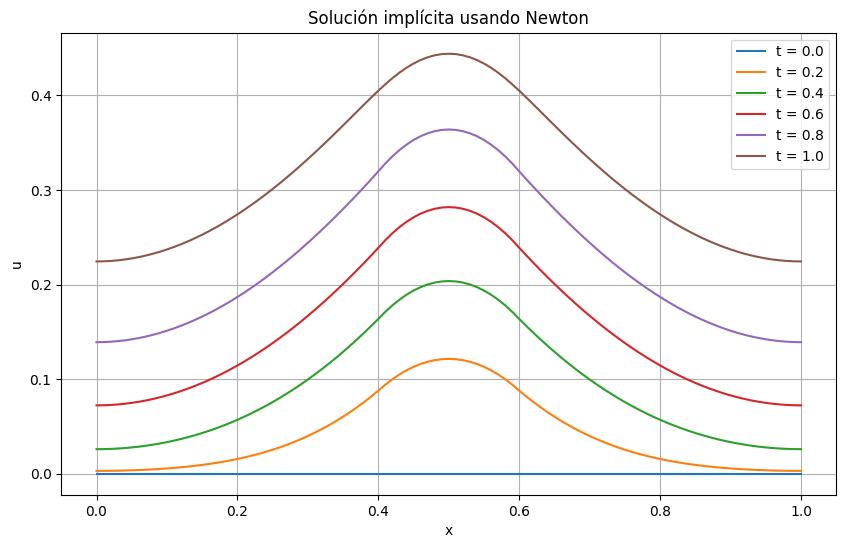

In [48]:
for n in range(N):
    u[n+1] = newton_step(u[n], t[n+1])

plt.figure(figsize=(10, 6))
for tn in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.plot(x, u[int(tn/tau)], label=f't = {tn}')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solución implícita usando Newton')
plt.legend()
plt.grid(True)
plt.show()


Se puede ver que la solución tiene sentido, ya que la función vale más en el centro en donde nos ayuda la función $f$. Además, se puede ver que hay "generación espontánea" en todo el rango debido al término no lineal $u(1 - u)$, el cual nos ayudará a crecer cuando $u < 1$. Otra observación es que en los bordes las derivadas tienden a ser más constantes debido a las condiciones propuestas para el borde. Así, la solución tiene sentido (y tiene mucho más sentido con otros experimentos que hice pero que no puse, como probar dejarla más tiempo, o dejar solución inicial en 1).

Ahora implementemos el método semi-implícito. Para esto hagamos la parte lineal $\mu \Delta u^{n+1}$ de forma implícita y la parte no lineal $u^n(1 - \left(u^n\right)^2) + f(t^n, x_i)$ de forma explícita. De esto resulta que  $$\frac{u_i^{n+1} - u_i^n}{\tau} = \mu \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2} + u_i^n(1 - (u_i^n)^2) + f(t^n, x_i) \quad \forall i \in \{1, \dots, M-1\}$$
Y en los bordes dejamos el esquema totalmente explícito ya que de todas formas no debiera 
$$\frac{u_0^{n+1} - u_0^n}{\tau} = \mu \frac{2(u_1^{n+1} - u_0^{n+1})}{h^2} + u_0^n(1 - (u_0^n)^2) + f(t^n, 0)$$
$$\frac{u_M^{n+1} - u_M^n}{\tau} = \mu \frac{2(u_{M-1}^{n+1} - u_M^{n+1})}{h^2} + u_M^n(1 - (u_M^n)^2) + f(t^n, 1)$$

In [58]:
def mixed_step(u_prev, tn):
    b = np.zeros(M+1)
    A = np.zeros((3, M+1))

    for i in range(M+1):
        xi = i * h
        fi = f(tn, xi)
        nonlinear = g(u_prev[i])

        if i == 0:
            b[i] = u_prev[i] + tau*(nonlinear + fi)
            A[1, i] = 1 + 2*tau*mu/h**2
            A[0, i+1] = -2*tau*mu/h**2
        elif i == M:
            b[i] = u_prev[i] + tau*(nonlinear + fi)
            A[1, i] = 1 + 2*tau*mu/h**2
            A[2, i-1] = -2*tau*mu/h**2
        else:
            b[i] = u_prev[i] + tau*(nonlinear + fi)
            A[0, i+1] = -tau*mu/h**2
            A[1, i] = 1 + 2*tau*mu/h**2
            A[2, i-1] = -tau*mu/h**2

    return solve_banded((1, 1), A, b)


Hagamos las simulaciones

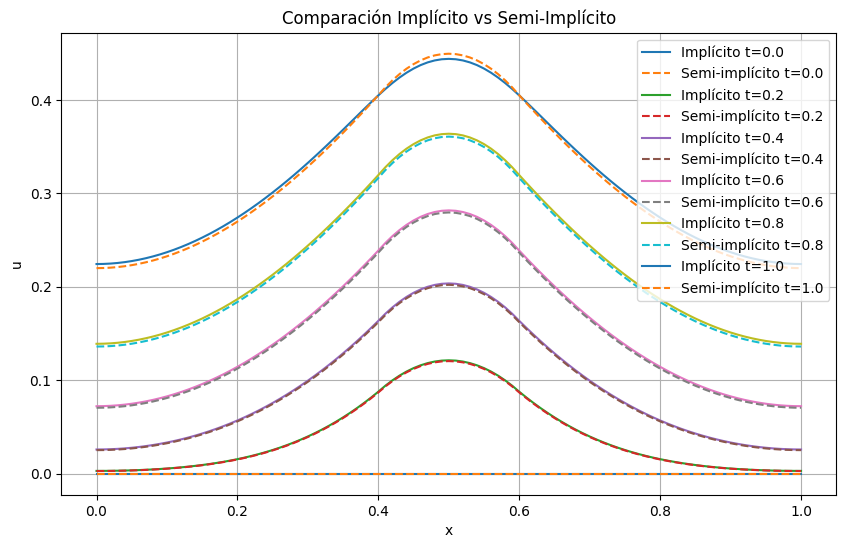

In [59]:
for n in range(N):
    u2[n+1] = mixed_step(u2[n], t[n])

plt.figure(figsize=(10, 6))
for tn in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    plt.plot(x, u[int(tn/tau)], label=f'Implícito t={tn}')
    plt.plot(x, u2[int(tn/tau)], '--', label=f'Semi-implícito t={tn}')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Comparación Implícito vs Semi-Implícito')
plt.legend()
plt.grid(True)
plt.show()


Se puede ver que los resultados son bastante similares, y por su parte en el esquema semi-implícito propuesto nos podemos ahorrar el método de Newton, por lo que es mucho más eficiente computacionalmente y es capaz de conseguir una solución prácticamente igual de buena. Así, se puede ver que este esquema puede ser muy beneficioso en ciertos casos.